# Multilayer Perceptron Regressor in Numpy from Scratch

In this notebook, I will implement a Neural Network from scratch using the Numpy library. The exact type of Neural Network we will build is a Multilayer Perceptron, also known as a Feedforward Neural Network. This is a densely connected Neural Network, that was described in detail in previous articles. Our Neural Network will be designed to handle regression problems involving datasets with 3 predictor input features, and output labels with dimension of 2.

Let's start by importing the necessary packages we will need into this notebook:

In [1]:
# imports
from typing import List, Tuple
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

Now we can create our implementation. The Neural Network we will build will tackle regression problems, and will be encapsulated in a single class called **MLP352Regressor**. The following simplifying assumptions will be made for this model:

1) The sigmoid activation function will be used for all hidden neurons
2) The linear activation function will be used for all output neurons
3) The squared difference loss function, described in a previous article (https://insidelearningmachines.com/how_neural_networks_learn/), will be used during training
4) I'm fixing the Neural Network to have an input layer with 3 neurons, a single hidden layer with 5 neurons, and an output layer with 2 neurons

## Model Implementation

In [14]:
class MLP352Regressor(object):
    """
    Class to encapsulate a Multilayer Perceptron / FeedForward Neural Network regressor
    """
    
    def __init__(self, lr: float=1e-2, epochs: int=100) -> None:
        """
        Initialiser function for a class instance
        
        Inputs:
            lr      -> learning rate
            epoches -> number of epoches to use during training
        """
        self.lr      = lr
        self.epochs  = epochs
        self.layers  = [3,5,2]
        self.weights = []
        self.biases  = []
        self.loss    = []
        
    def __del__(self) -> None:
        """
        Destructor function for a class instance
        """
        del self.lr
        del self.epochs
        del self.layers
        del self.weights
        del self.biases
        del self.loss
        
    def _loss(self, y_true: np.array, y_pred: np.array) -> np.array:
        """
        Function to compute squared-error loss per sample
        
        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return 0.5*(y_true - y_pred)**2
    
    def _derivative_loss(self, y_true: np.array, y_pred: np.array) -> np.array:
        """
        Function to compute the derivative of the squared-error loss per sample
        
        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return -(y_true - y_pred)
    
    def _sigmoid(self, z: np.array) -> np.array:
        """
        Function to compute sigmoid activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return 1/(1+np.exp(-z))
    
    def _derivative_sigmoid(self, z: np.array) -> np.array:
        """
        Function to compute the derivative of the sigmoid activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return self._sigmoid(z)*(1 - self._sigmoid(z))
    
    def _linear(self, z: np.array) -> np.array:
        """
        Function to compute linear activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return z

    def _derivative_linear(self, z: np.array) -> np.array:
        """
        Function to compute the derivative of the linear activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return np.ones(z.shape)
    
    def _forward_pass(self, X: np.array) -> Tuple[List[np.array], List[np.array]]:
        """
        Function to perform forward pass through the network
        
        Input:
            X -> numpy array of input predictive features with assumed shape [number_features, number_samples]
        Output:
            list of activations & derivatives for each layer
        """ 
        # record from input layer
        input_to_layer = np.copy(X)
        activations    = [input_to_layer]
        derivatives    = [np.zeros(X.shape)]
        
        # hidden layer
        z_i = np.matmul(self.weights[0],input_to_layer) + self.biases[0]
        input_to_layer = self._sigmoid(z_i)
        activations.append(input_to_layer)
        derivatives.append(self._derivative_sigmoid(z_i))
        
        # output layer
        z_i = np.matmul(self.weights[1],input_to_layer) + self.biases[1]
        input_to_layer = self._linear(z_i)
        activations.append(input_to_layer)
        derivatives.append(self._derivative_linear(z_i))
        
        # return results
        return(activations, derivatives)
    
    def _backward_pass(self, 
                       activations: List[np.array], 
                       derivatives: List[np.array], 
                       y: np.array) -> Tuple[List[np.array], List[np.array]]:
        """
        Function to perform backward pass through the network
        
        Inputs:
            activations -> list of activations from each layer in the network
            derivatives -> list of derivatives from each layer in the network
            y           -> numpy array of target values 
                           with assumed shape [output dimension, number_samples]
        Output:
            list of numpy arrays containing the derivates of the loss function wrt layer weights
        """ 
        # record loss
        self.loss.append((1/y.shape[1])*np.sum(self._loss(y, activations[-1])))
        
        # output layer
        dl_dy2 = self._derivative_loss(y, activations[2])
        dl_dz2 = np.multiply(dl_dy2, derivatives[2])
        dl_dw2 = (1/y.shape[1])*np.matmul(dl_dz2, activations[1].T)
        dl_db2 = (1/y.shape[1])*np.sum(dl_dz2, axis=1)
        
        # hidden layer
        dl_dy1 = np.matmul(self.weights[1].T, dl_dz2)
        dl_dz1 = np.multiply(dl_dy1, derivatives[1])
        dl_dw1 = (1/y.shape[1])*np.matmul(dl_dz1, activations[0].T)
        dl_db1 = (1/y.shape[1])*np.sum(dl_dz1, axis=1)
        
        # return derivatives
        return([dl_dw1, dl_dw2], [dl_db1, dl_db2])
    
    def _update_weights(self, dl_dw: List[np.array], dl_db: List[np.array]) -> None:
        """
        Function to apply update rule to model weights
        
        Input:
            dl_dw -> list of numpy arrays containing loss derivatives wrt weights
        """
        self.weights[0] -= self.lr*dl_dw[0]
        self.weights[1] -= self.lr*dl_dw[1]
        self.biases[0]  -= self.lr*dl_db[0].reshape(-1,1)
        self.biases[1]  -= self.lr*dl_db[1].reshape(-1,1)
        
    def fit(self, X: np.array, y: np.array) -> None:
        """
        Function to train a class instance
        
        Inputs:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
            y -> numpy array of target values with assumed shape [number_samples, output dimension]
        """
        # initialise the model parameters
        self.weights.clear()
        self.biases.clear()
        self.loss.clear() 
        for idx in range(len(self.layers)-1):
            self.weights.append(np.random.randn(self.layers[idx+1], self.layers[idx]) * 0.1)
            self.biases.append(np.random.randn(self.layers[idx+1], 1) * 0.1)         
        # loop through each epoch
        for _ in range(self.epochs):
            # do forward pass through the network
            activations, derivatives = self._forward_pass(X.T)
            # do backward pass through the network
            dl_dw, dl_db = self._backward_pass(activations, derivatives, y.T)
            # update weights
            self._update_weights(dl_dw, dl_db)   
            
    def predict(self, X: np.array) -> np.array:
        """
        Function to produce predictions from a trained class instance
        
        Input:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
        Output:
            numpy array of model predictions
        """
        # do forward pass through the network
        activations, _ = self._forward_pass(X.T)
        # return predictions
        return activations[2].T

## Create Dataset

Let's produce a dataset with 10000 samples, consisting of 3 predictive input features, and targets with a dimension of 2. Some minimal gaussian noise is also added:

In [3]:
# generate data
X, y = make_regression(n_samples=10000, n_features=3, n_targets=2, noise=1, random_state=42)

We can produce some box plots to get a sense of the distribution in these data:

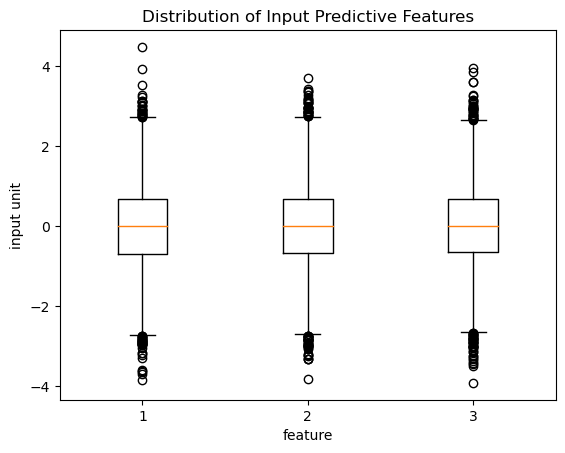

In [7]:
plt.boxplot(X)
plt.title("Distribution of Input Predictive Features")
plt.xlabel("feature")
plt.ylabel("input unit")
plt.show()

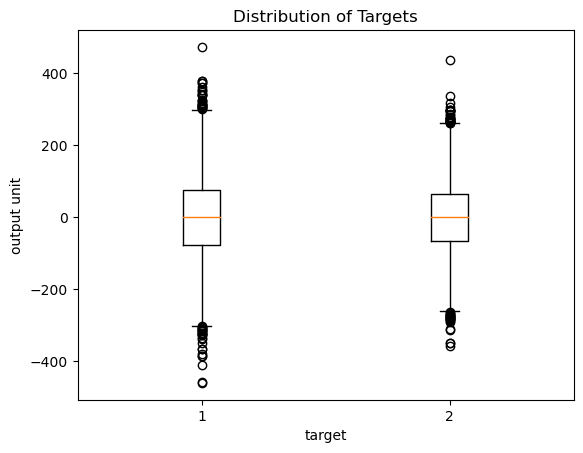

In [9]:
plt.boxplot(y)
plt.title("Distribution of Targets")
plt.xlabel("target")
plt.ylabel("output unit")
plt.show()

Both the input features, and targets, appear to be approximately zero-centered. The bulk of the input features range from $(-3, +3)$, whereas the output targets mostly range between $(-300, +300)$

Finally, we can do a train-test split, with 80% of the data being allocated for training:

In [10]:
# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Test Model

Now let's create an instance of our implemented class, and train it on the training data. I'll use a learning rate of 0.01, and we'll train for 1500 epochs:

In [15]:
# train the regressor
model = MLP352Regressor(lr=0.01, epochs=1500)
model.fit(X_train,y_train)

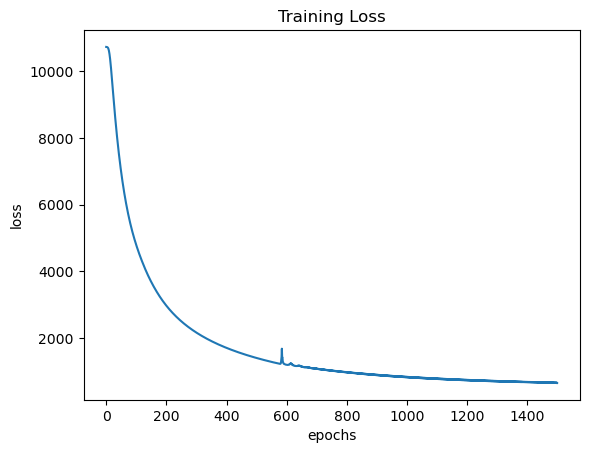

In [17]:
# plot the training loss
plt.plot(model.loss)
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Plotting the training loss shows a smooth decline in the loss value as each subsequent epoch is executed. This highlights that our training procedure is working as expected. Now let's evaluate how well our regressor performs in making predictions:

In [18]:
# generate predictions
y_pred = model.predict(X_test)

In [19]:
# evaluate model performance
print(f"mse: {mean_squared_error(y_test, y_pred):.2f} and mae: {mean_absolute_error(y_test, y_pred):.2f}")

mse: 664.84 and mae: 16.53


The MAE result indicates that the bulk of the predictions are fairly close to the true values. However the large MSE value shows there are outliers where the model hasn't made very good predictions. Let's view a few samples to check for this:

In [21]:
y_test

array([[  96.0652615 ,  105.2753081 ],
       [  70.01592472,  169.33894413],
       [ 136.81237065,  165.87554143],
       ...,
       [ -76.98996266, -113.78059034],
       [ 206.96193285,  256.91509498],
       [ -39.808533  ,   -9.71756154]])

In [22]:
y_pred

array([[  97.76151633,  101.12347451],
       [  70.88374713,   99.54522216],
       [ 136.31562322,  126.56560826],
       ...,
       [ -85.5870685 , -100.21340972],
       [ 169.65014163,  141.53248125],
       [ -46.55959464,   -9.32616964]])

Looking at these numbers, it's evident that while most of the predictions are fairly reasonable, there are some points where the predictions are significantly different from the truth.